## Pipeline  流水线
- 实战案例
- 原理解析

> transformer初级用法，适合新人快速上手

### 实战案例
Transformers 库最基础的对象就是 pipeline() 函数，它封装了预训练模型和对应的前处理和后处理环节。我们只需输入文本，就能得到预期的答案。目前常用的 pipelines 有：

- feature-extraction （获得文本的向量化表示）
- fill-mask （填充被遮盖的词、片段）
- ner（命名实体识别）
- question-answering （自动问答）
- sentiment-analysis （情感分析）
- summarization （自动摘要）
- text-generation （文本生成）
- translation （机器翻译）
- zero-shot-classification （零训练样本分类）

#### 情感分析
基于 pipeline，我们只需要输入文本即可得到结果
```
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
result = classifier("I've been waiting for a HuggingFace course my whole life.")
print(result)
results = classifier(
  ["I've been waiting for a HuggingFace course my whole life.", "I hate this so much!"]
)
print(results)

```

#### 零训练样本分类(中文demo)
```
classifier = pipeline("zero-shot-classification", model="morit/chinese_xlm_xnli")
result = classifier("这是一个关于transformer的课程",candidate_labels=["education", "politics", "business"], multi_label=False)
print(result)

```


#### 文本生成(中文demo)
- 我们首先根据任务需要构建一个模板 (prompt)，然后将其送入到模型中来生成后续文本
```
generator = pipeline("text-generation")
results = generator("In this course, we will teach you how to")
print(results)
results = generator(
    "In this course, we will teach you how to",
    num_return_sequences=2,
    max_length=50
)
print(results)
```


#### 古诗生成
```
generator = pipeline("text-generation", model="uer/gpt2-chinese-poem")
results = generator(
    "[CLS] 万 叠 春 山 积 雨 晴 ，",
    max_length=40,
    num_return_sequences=2,
)
print(results)

```


#### 问答 demo
```
question_answerer = pipeline("question-answering")
answer = question_answerer(
    question="Where do I work?",
    context="My name is Sylvain and I work at Hugging Face in Brooklyn",
)
print(answer)

```

 ## pipeline背后的原理（新手推荐使用）

三个步骤：

- 预处理 (preprocessing)，将原始文本转换为模型可以接受的输入格式；
- 将处理好的输入送入模型；
- 对模型的输出进行后处理 (postprocessing)，将其转换为人类方便阅读的格式。

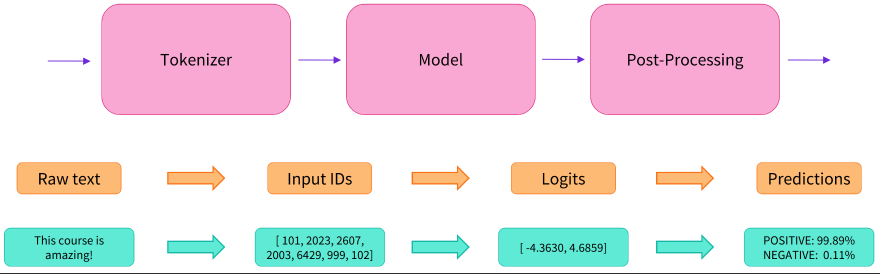

### 使用分词器进行预处理
首先需要通过预处理环节将文本转换为模型可以理解的数字。具体地，我们会使用每个模型对应的分词器 (tokenizer) 来进行：

- 将输入切分为词语、子词或者符号（例如标点符号），统称为 tokens；
- 根据模型的词表将每个 token 映射到对应的 token 编号（就是一个数字）；
- 根据模型的需要，添加一些额外的输入。

我们对输入文本的预处理需要与模型自身预训练时的操作完全一致，只有这样模型才可以正常地工作。这里我们使用 AutoTokenizer 类和它的 from_pretrained() 函数，它可以自动根据模型 checkpoint 名称来获取对应的分词器。

**AutoTokenizer已经根据模型的不同做了个性化处理**



```
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)
```

输出中包含两个键 input_ids 和 attention_mask，其中 input_ids 对应分词之后的 tokens 映射到的数字编号列表

而 attention_mask 则是用来标记哪些 tokens 是被填充的（这里“1”表示是原文，“0”表示是填充字符）

### 输入模型
预训练模型的下载方式和分词器 (tokenizer) 类似，Transformers 包提供了一个 AutoModel 类和对应的 from_pretrained() 函数

```
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)
```

预训练模型的本体只包含基础的 Transformer 模块，对于给定的输入，它会输出一些神经元的值，称为 hidden states 或者特征 (features)。对于 NLP 模型来说，可以理解为是文本的高维语义表示。这些 hidden states 通常会被输入到其他的模型部分（称为 head），以完成特定的任务，例如送入到分类头中完成文本分类任务。

其实前面我们举例的所有 pipelines 都具有类似的模型结构，只是模型的最后一部分会使用不同的 head 以完成对应的任务。

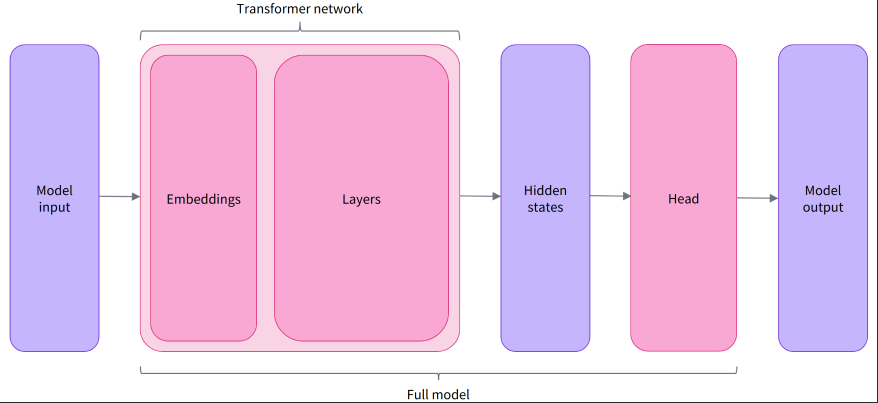

Transformers 库封装了很多不同的结构，常见的有：

- *Model （返回 hidden states）
- *ForCausalLM （用于条件语言模型）
- *ForMaskedLM （用于遮盖语言模型）
- *ForMultipleChoice （用于多选任务）
- *ForQuestionAnswering （用于自动问答任务）
- *ForSequenceClassification （用于文本分类任务）
- *ForTokenClassification （用于 token 分类任务，例如 NER）

Transformer 模块的输出是一个维度为 (Batch size, Sequence length, Hidden size) 的三维张量，

其中 Batch size 表示每次输入的样本（文本序列）数量，即每次输入多少个句子，上例中为 2；

Sequence length 表示文本序列的长度，即每个句子被分为多少个 token，上例中为 16；

Hidden size 表示每一个 token 经过模型编码后的输出向量（语义表示）的维度。

我们可以打印出这里使用的 distilbert-base 模型的输出维度：

```
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

```

对于情感分析任务，很明显我们最后需要使用的是一个文本分类 head。因此，实际上我们不会使用 AutoModel 类，而是使用 AutoModelForSequenceClassification：

```
print(outputs.logits.shape)

torch.Size([2, 2])
```

可以看到，对于 batch 中的每一个样本，模型都会输出一个两维的向量（每一维对应一个标签，positive 或 negative）。


### 输出后处理
由于模型的输出只是一些数值，因此并不适合人类阅读。例如我们打印出上面例子的输出：

```
print(outputs.logits)

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)
```
模型对第一个句子输出[-1.5607,  1.6123]，对第二个句子输出[ 4.1692, -3.3464]，它们并不是概率值，而是模型最后一层输出的 logits 值。要将他们转换为概率值，还需要让它们经过一个 SoftMax 层，



```
import torch
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)
```

这样模型的预测结果就是容易理解的概率值：第一个句子[4.0195e-02, 9.5980e-01]，第二个句子[9.9946e-01, 5.4418e-04]
。最后，为了得到对应的标签，可以读取模型 config 中提供的 id2label 属性：

```
print(model.config.id2label)

{0: 'NEGATIVE', 1: 'POSITIVE'}
```

于是我们可以得到最终的预测结果：

- 第一个句子: NEGATIVE: 0.0402, POSITIVE: 0.9598
- 第二个句子: NEGATIVE: 0.9995, POSITIVE: 0.0005

## 参考：

### 源码
https://colab.research.google.com/drive/1Ej3Fg62o7JAxbcdCQYF_3j0obB0eO16f#scrollTo=9pFS2KPzd0Oe

### 引用
- https://zhuanlan.zhihu.com/p/448852278
- https://transformers.run/back/transformer/